## Extracting the information you need from a (very) large online dataset ##

If you think you can't work with datasets that are tens of Gigabytes in size, then think again! In this notebook, I demonstrate how you can remotely access, slice, manipulate and analyze data within a few lines of code. Our use case is global analysis of change, so the tools and examples also focus on this. In between, we will also see some plotting utilities pop up that may come in handy. What we will do is:
-
-

Some short-keys:
* Ctrl-Enter: run the current cell
* Shift-Enter: run the current cell and move to the next
* Alt-Enter: run the current cell and insert an empty cell below


First we have to tell python that we want to visualize things with a package called matplotlib, and that we want to visualize things within this notebook (rather than in separate windows). We also need to load a few libraries we'll be using throughout. These are the following:
* pandas for time series analysis
* xarray for speaking to online large datasets in NetCDF file format
* matplotlib.pyplot, a very nice plotting library
* cartopy, an add-on for matplotlib that plots stuff on geographical maps
* cartopy.ccrs, sublibrary of cartopy that does projection from one to another

In [7]:
%matplotlib inline
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as feature

We will work with the Earth2Observe forcing data. These data include records of temperature, precipitation and other meteorological variables across the globe. The data were used in the Earth2Observe project to run an ensemble of global scale hydrological models to come up with a global scale reanalysis that can be used for global water resources analyses. 

The first step: select an online datafile on an OPeNDAP server and open it with xarray. Have a look at its global contents.

In [2]:
# define url
url = r'https://wci.earth2observe.eu/thredds/dodsC/jrc/mswep-rainf-daily-agg.nc'
# open with xarray into a dataset (ds). You are only looking at metadata of a very large dataset
ds = xr.open_dataset(url)
# let's have a look...
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 13149)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 -179.875 -179.625 -179.375 -179.125 -178.875 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 1979-01-03 ...
Data variables:
    Rainf    (time, lat, lon) float64 ...
Attributes:
    references:        Beck, H. E., van Dijk, A. I. J. M., Levizzani, V., Sch...
    date_modified:     Fri Jun 17 08:47:33 2016
    history:           Mon May 15 09:45:00 2017: ncatted -O -a standard_name,...
    NCO:               "4.6.2"
    _CoordSysBuilder:  ucar.nc2.dataset.conv.DefaultConvention

Ok, it seemed to open fine. We see that the dataset contains three coordinate dimensions (lat, lon and time) over which we can select data. There are 720 latitude steps, 1440 longitude steps and 13149 time steps. Furthermore, there is one variable, that spans these three dimensions called "Rainf". Finally, we see it contains some global metadata called "attributes". Now I'll show you how to look at one variables

In [4]:
precip = ds['Rainf']
precip

<xarray.DataArray 'Rainf' (time: 13149, lat: 720, lon: 1440)>
[747981312 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 -179.875 -179.625 -179.375 -179.125 -178.875 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 1979-01-03 ...
Attributes:
    standard_name:  rainfall_flux
    units:          kg m-2 s-1
    long_name:      Rainfall rate
    cell_methods:   time: mean (interval: 0h-24h UTC)
    _ChunkSizes:    [   1  720 1440]

We now see more details abou8t the "Rainf" variable. According to its attributes, it contains Mean daily rainfall rates in units kg per square meter per second (kg m-2 s-1). Now let's retrieve the first time step (index is zero) and make a nice plot of this. xarray is fully object-oriented and has nice plot functionalities.

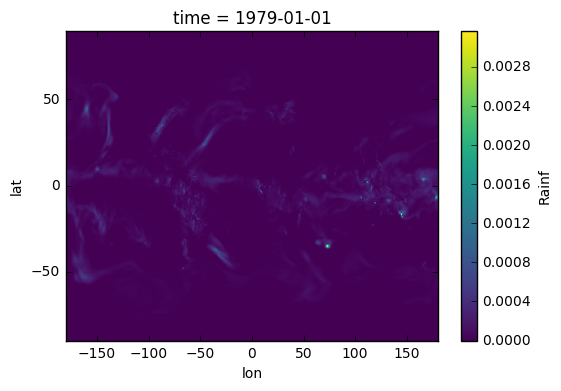

In [7]:
precip_first = precip[0]
precip_first.plot()

Ok, cool, we see some vague precipitation patterns, but difficult to make out where. If you want to have a nice geographical plot, we first need to setup an axis with some coastline outlined, then repeat the command. It is also more easy to understand when we use millimeters per day and cut it off at 50 millimetres.

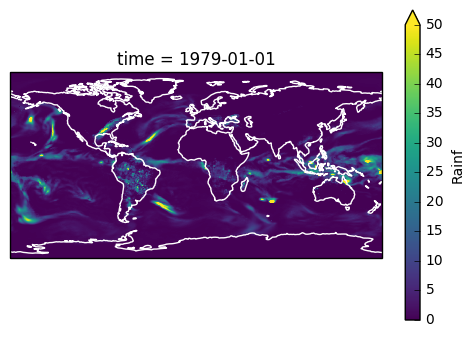

In [16]:
ax = plt.axes(projection=ccrs.PlateCarree())
precip_first_mm = precip_first*86400.
precip_first_mm.plot(ax=ax, vmin=0., vmax=50.)  # we tell the command to use the geographical axis just defined

ax.coastlines(color='w')

So what actually happended here?
* First we opened the url and parsed its contents in ds. Wait a minute, that can't be right, the dataset is huge and it only took a few seconds!!
* No, we only opened it and downloaded a little bit of information about its contents. Just the metadata on variables and dimensions was extracted. ds, only is a reference to the dataset.
* Then we selected the first [0] time step. Even in this selection process, no actual numbers were downloaded yet, just a pipeline to the data was setup
* finally, we made a plot, and yes, that is where data is actually downloaded!

So what if we want to slice in a different way? You can also slice a particular latitude longitude location! Let's try that for the Netherlands

In [20]:
# lat and lon location of Amsterdam (by googling amsterdam latitude longitude)
lat = 52.37
lon = 4.89
# now slice a particular point, using the sel_points (select points) slicer
precip.sel_points(lon=[lon], lat=[lat], method='nearest')


MemoryError: 

Ooops, we probably hit a memory error here, did we do something wrong? Well....yes and no. It means we are approaching the dataset in the wrong chunks. Probably, the dataset is approached per time slice, and therefore, we'd have to go through the whole dataset to find the one lat lon location we are interested in. Let's chunk it so that it reads per full time slice.

In [27]:
ds = ds.chunk({'lat': 1, 'lon': 1, 'time': 13149})

In [29]:
# let's try again
precip = ds['Rainf']
p_amsterdam = precip.sel_points(lon=[lon], lat=[lat], method='nearest')
p_amsterdam

It did something, and it contains one point, and all time steps. So far, it only indexed the download. Let's see if we can download this and plot it. If you want to make sure the data is downloaded AND stored into a variable without having to download it again upon each operation, use the .load() command.

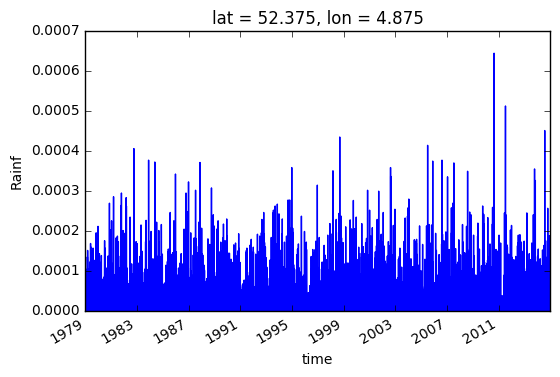

In [33]:
p_memory = p_amsterdam.load()
p_memory.plot()

That worked nicely didn't it? It did take a while, because the manner in which the data is stored on disk (per time step, or per lat/lon coordinate) also matters. We can also select a limited time slice, if we want. Let us now assume you want to have rainfall over the last year in record for the whole of the Netherlands. How do we do that? Let's first select small lat/lon blocks as chunks and narrow down the dataset to the Netherlands

In [2]:
# ds.close()
# let's reopen with the right chunksize
url = r'https://wci.earth2observe.eu/thredds/dodsC/jrc/mswep-rainf-daily-agg.nc'

ds = xr.open_dataset(url, chunks={'time': 10, 'lat': 25, 'lon': 25}, lock=True)
# bounding box found with http://boundingbox.klokantech.com/
ds_nl = ds.sel(lat=slice(50.5, 53.7), lon=slice(3, 7.5))
precip_nl = ds_nl['Rainf']*86400.
precip_nl
# let's plot the first time step again
# precip_nl[0].plot()

NotImplementedError: cannot use ``method`` argument if any indexers are slice objects

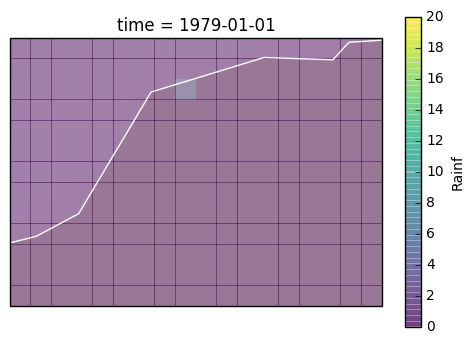

In [10]:
ds_nl = ds.sel(lat=slice(50.5, 53.7), lon=slice(3, 7.5))
precip_nl = ds_nl['Rainf']*86400.
# precip_nl[0].plot()

ax = plt.axes(projection=ccrs.PlateCarree())
precip_nl[0].plot(ax=ax, vmin=0., vmax=20., alpha=0.5)  # we tell the command to use the geographical axis just defined

ax.coastlines(color='w')
ax.add_feature(feature.LAND, color='w', zorder=0)

Not a very interesting day, but now let us slice a full year and load it into memory (only 13x14x365 numbers)

In [29]:
%timeit -r 1 -n 1 p_lastyear = precip_nl[-365:].load()


1 loop, best of 1: 17.9 s per loop


we see that all the number are now loaded in memory. Now we can start doing nice manipulations. For instance, what if we want to know the sum of rainfall in the whole year in mm. We simply take the sum over the time axis. We use a filled contour plot with 20 levels to make a nice plot

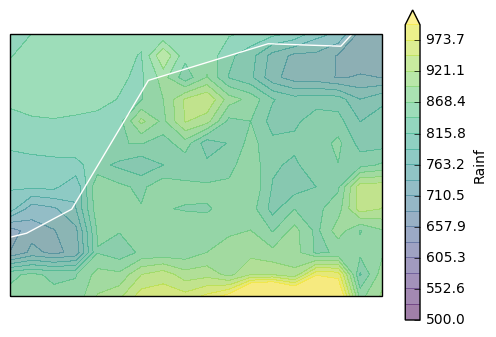

In [23]:
p_sum = p_lastyear.sum(dim='time')

ax = plt.axes(projection=ccrs.PlateCarree())
p_sum.plot.contourf(ax=ax, vmin=500, vmax=1000., alpha=0.5, levels=20)  # we tell the command to use the geographical axis just defined
ax.coastlines(color='w')
ax.add_feature(feature.LAND, color='w', zorder=0)

What about monthly averages? That we can do by grouping all time steps per month, and then sum these groups. Then we show the january precip.

ValueError: DataArray must be 2d

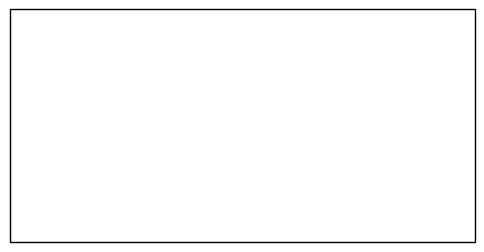

In [28]:
p_monthly = p_lastyear.groupby('time.month').sum(dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())
p_monthly.plot.contourf(ax=ax, vmin=10, vmax=100., alpha=0.5, levels=20)  # we tell the command to use the geographical axis just defined
ax.coastlines(color='w')
ax.add_feature(feature.LAND, color='w', zorder=0)
